## 3.1 

At this point, you understand the data well. For your group proposed project, you must
explore some aspects of machine learning models. You must use the dataset given but
you may use additional datasets to supplement your analysis (e.g., weather data), look
at unaggregated data, look at the difference in carpark availability for carparks with free
parking, etc. Note that you are not limited to the initial proposal and are free to expand
on it.

## 3.2

Based on the insights derived from the analysis, suggest a practical action that can be
taken in approximately 200 words (i.e., an action that can be taken to benefit society.
Do not suggest actions such as hyperparameter tuning here). You do not need to carry
out the action. A simple example is, if the team had made models to predict carpark
availability of individual carparks in Q3.1, then these models can be used to develop
an application to the public that forecasts carpark availability to reduce congestion in
carparks during peak hours.

# Data Required: 
Local Datasets(Pertain to Project)
- Carpark Availability Datasets - Done
- HDB information Carpark Information (Already got the data) - group data by keywords short term['yes'] or no and other types - Done
- LTA DataMall - Road Works(Approved) (not done)
Training Data: August 2021, Aug 2023, July 2024 #fit into the model combine into a single csv(Done)
Test Data: August 2024 - Predict from the test data(Introduce lagged features) - lag(push further out) 168- weekly(Long term), lag(1) - 1 hour - short term - to fit into XGboost Model
External Data: 
Weather Data API(NEA) - Rainfall 

Side note: 
if given sufficient time 
- Events / Dates API Data(Extract relevant features)
- Shorter time frame datasets(Half and Hour)


ramana datasets
Test Set: Oct 2022 
Training DataSets: Aug 2022, Oct 2019, Oct 2021, Sept 2022

Steps: 
Preprocessing the data and clean it and filter and sort by carpark types 

# Contents
- Problem Statement
- Overview
- Gradient Boosting(XGBOOST) and Suggestion of Carparks based on Geolocation(HDB Carpark Information)
- Data Collection and Processing(Standard Scalar, and Removing missing and empty values datas)
- Training, validation and testing of XGBoost / LightGBM Model（Regressors)
- Training and testing of Decision Tree Regressor Model #baseline model
- Evaluation of performance of XGBoost and DTR per cluster
- Sample Functions for Problem Statement
- Limitations in Project
- Potential Improvements and Model Usage
- Conclusion
- Summary for Question 3


Algorithms(Process Flow): 
 1. Filter out a list of open carparks based on arrival hour. 
2. Calculate the total number of available carparks based on the HDB geocoordinates - eg. get the geocoordinates 
3. Group By Clustering by the Geolocations of the carparks(HDB information)
3. Predict carpark availability for the top chosen carparks with the given arrival hour using the ML model with 
    LSTM and XGBoost Comparisons
4. Choose from the suggested the top 5 most available carparks with the highest performance metrics(RMSE), 
5. Display the recommended carpark list with availability and distance to the user, sorted by availability (highest to lowest).

# Data Collection and Preprocessing

In [52]:
#Libraries are all here

import requests
import json
import pandas as pd
import datetime
import numpy as np 
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn import datasets, metrics
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt #visualization 
import seaborn as sns 
import math 
import warnings
import time
from datetime import datetime, timedelta
import glob
from sklearn.model_selection import train_test_split




# Collection of Training Datasets Across the Years 2021, 2023, 2024

In [61]:
#Extract the data for the month of July(Year 2024) - Historical 
#Create Lagged features based on the temporal dependencies of the August 2024 Datasets 
#Extract the data for the month of Aug(Year 2024) - Historical  - Test Dataset

# Set the year and month for Aug 2024
year = "2024"
month = "7"
start_date = datetime(int(year), int(month), 1, 0, 0)    # Start of July
end_date = datetime(int(year), int(month) + 1, 1, 0, 0)  # Start of August

carpark_availability_data = []

# Loop over each hour in July 2024
current_date = start_date
while current_date < end_date:
    # Format the API endpoint for each hour
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{current_date.day:02}T{current_date.hour:02}%3A00%3A00'
    print(f"Fetching data from: {site}")
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = response_API.json()
        
        # Check if 'items' and 'carpark_data' exist
        if "items" in data and len(data["items"]) > 0 and "carpark_data" in data["items"][0]:
            timestamp = data["items"][0]["timestamp"]
            carpark_data = data["items"][0]["carpark_data"]

            # Calculate availability ratio for each carpark
            hourly_data = []
            for carpark in carpark_data:
                if "carpark_info" in carpark and carpark["carpark_info"]:
                    total_lots = int(carpark["carpark_info"][0].get("total_lots", 0))
                    lots_available = int(carpark["carpark_info"][0].get("lots_available", 0))
                    
                    # Ensure total_lots is greater than 0 to avoid division by zero
                    if total_lots > 0:
                        availability_ratio = lots_available / total_lots
                        hourly_data.append(availability_ratio)

            # Store average availability ratio for the hour across all carparks
            if hourly_data:
                average_availability = sum(hourly_data) / len(hourly_data)
                carpark_availability_data.append({
                    "timestamp": timestamp, 
                    "average_availability": average_availability
                })

    # Increment time by one hour
    current_date += timedelta(hours=1)

# Create DataFrame and convert timestamp to datetime
df = pd.DataFrame(carpark_availability_data)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Save DataFrame to CSV file
df.to_csv("Carpark_Availability_July_2024_New.csv", index=False)

############################## Aug 2023 #################################

year = "2023"
month = "8"
start_date = datetime(int(year), int(month), 1, 0, 0)    # Start of July
end_date = datetime(int(year), int(month) + 1, 1, 0, 0)  # Start of August

carpark_availability_data = []

# Loop over each hour in July 2024
current_date = start_date
while current_date < end_date:
    # Format the API endpoint for each hour
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{current_date.day:02}T{current_date.hour:02}%3A00%3A00'
    print(f"Fetching data from: {site}")
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = response_API.json()
        
        # Check if 'items' and 'carpark_data' exist
        if "items" in data and len(data["items"]) > 0 and "carpark_data" in data["items"][0]:
            timestamp = data["items"][0]["timestamp"]
            carpark_data = data["items"][0]["carpark_data"]

            # Calculate availability ratio for each carpark
            hourly_data = []
            for carpark in carpark_data:
                if "carpark_info" in carpark and carpark["carpark_info"]:
                    total_lots = int(carpark["carpark_info"][0].get("total_lots", 0))
                    lots_available = int(carpark["carpark_info"][0].get("lots_available", 0))
                    
                    # Ensure total_lots is greater than 0 to avoid division by zero
                    if total_lots > 0:
                        availability_ratio = lots_available / total_lots
                        hourly_data.append(availability_ratio)

            # Store average availability ratio for the hour across all carparks
            if hourly_data:
                average_availability = sum(hourly_data) / len(hourly_data)
                carpark_availability_data.append({
                    "timestamp": timestamp, 
                    "average_availability": average_availability
                })

    # Increment time by one hour
    current_date += timedelta(hours=1)

# Create DataFrame and convert timestamp to datetime
df = pd.DataFrame(carpark_availability_data)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Save DataFrame to CSV file
df.to_csv("Carpark_Availability_Aug_2023_New.csv", index=False)




############################## Aug 2021 #################################

year = "2021"
month = "8"
start_date = datetime(int(year), int(month), 1, 0, 0)    # Start of July
end_date = datetime(int(year), int(month) + 1, 1, 0, 0)  # Start of August

carpark_availability_data = []

# Loop over each hour in July 2024
current_date = start_date
while current_date < end_date:
    # Format the API endpoint for each hour
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{current_date.day:02}T{current_date.hour:02}%3A00%3A00'
    print(f"Fetching data from: {site}")
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = response_API.json()
        
        # Check if 'items' and 'carpark_data' exist
        if "items" in data and len(data["items"]) > 0 and "carpark_data" in data["items"][0]:
            timestamp = data["items"][0]["timestamp"]
            carpark_data = data["items"][0]["carpark_data"]

            # Calculate availability ratio for each carpark
            hourly_data = []
            for carpark in carpark_data:
                if "carpark_info" in carpark and carpark["carpark_info"]:
                    total_lots = int(carpark["carpark_info"][0].get("total_lots", 0))
                    lots_available = int(carpark["carpark_info"][0].get("lots_available", 0))
                    
                    # Ensure total_lots is greater than 0 to avoid division by zero
                    if total_lots > 0:
                        availability_ratio = lots_available / total_lots
                        hourly_data.append(availability_ratio)

            # Store average availability ratio for the hour across all carparks
            if hourly_data:
                average_availability = sum(hourly_data) / len(hourly_data)
                carpark_availability_data.append({
                    "timestamp": timestamp, 
                    "average_availability": average_availability
                })

    # Increment time by one hour
    current_date += timedelta(hours=1)

# Create DataFrame and convert timestamp to datetime
df = pd.DataFrame(carpark_availability_data)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Save DataFrame to CSV file
df.to_csv("Carpark_Availability_Aug_2021_New.csv", index=False)



Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T00%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T01%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T02%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T03%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T04%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T05%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T06%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T07%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-07-01T08%3A

In [58]:
#Create Lagged features based on the temporal dependencies of the August 2024 Datasets 
#Extract the data for the month of Aug(Year 2024) - Historical  - Test Dataset

# Set the year and month for Aug 2024
year = "2024"
month = "8"
start_date = datetime(int(year), int(month), 1, 0, 0)    # Start of July
end_date = datetime(int(year), int(month) + 1, 1, 0, 0)  # Start of August

carpark_availability_data = []

# Loop over each hour in July 2024
current_date = start_date
while current_date < end_date:
    # Format the API endpoint for each hour
    site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{current_date.day:02}T{current_date.hour:02}%3A00%3A00'
    print(f"Fetching data from: {site}")
    response_API = requests.get(site)

    if response_API.status_code == 200:
        data = response_API.json()
        
        # Check if 'items' and 'carpark_data' exist
        if "items" in data and len(data["items"]) > 0 and "carpark_data" in data["items"][0]:
            timestamp = data["items"][0]["timestamp"]
            carpark_data = data["items"][0]["carpark_data"]

            # Calculate availability ratio for each carpark
            hourly_data = []
            for carpark in carpark_data:
                if "carpark_info" in carpark and carpark["carpark_info"]:
                    total_lots = int(carpark["carpark_info"][0].get("total_lots", 0))
                    lots_available = int(carpark["carpark_info"][0].get("lots_available", 0))
                    
                    # Ensure total_lots is greater than 0 to avoid division by zero
                    if total_lots > 0:
                        availability_ratio = lots_available / total_lots
                        hourly_data.append(availability_ratio)

            # Store average availability ratio for the hour across all carparks
            if hourly_data:
                average_availability = sum(hourly_data) / len(hourly_data)
                carpark_availability_data.append({
                    "timestamp": timestamp, 
                    "average_availability": average_availability
                })

    # Increment time by one hour
    current_date += timedelta(hours=1)

# Create DataFrame and convert timestamp to datetime
df = pd.DataFrame(carpark_availability_data)
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Save DataFrame to CSV file
df.to_csv("Carpark_Availability_Aug_2024_New.csv", index=False)


Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T00%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T01%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T02%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T03%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T04%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T05%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T06%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T07%3A00%3A00
Fetching data from: https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2024-08-01T08%3A

In [74]:
#Transform the data with lag shift.lag - test data

#Apply shift lag to the test dataset lag(24) - 1 day and lag 168 for 1 week 
# Load your dataset (replace with the path to your file)


# Load the dataset (replace with the path to your file)
file_path = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\Tests_Data\Carpark_Availability_Aug_2024_New.csv"
august_2024_lag = pd.read_csv(file_path)

# Print columns to confirm the correct name for the availability column
print("Columns in dataset:", august_2024_lag.columns)

# Convert the timestamp column to datetime format and set it as the index
august_2024_lag['timestamp'] = pd.to_datetime(august_2024_lag['timestamp'])
august_2024_lag.set_index('timestamp', inplace=True)

# Define the lags array
lags = [1, 168]  # hourly, and weekly

# Generate lag features
availability_column = 'average_availability'  # Replace with the actual column name if different
for lag in lags:
    august_2024_lag[f'lag_{lag}'] = august_2024_lag[availability_column].shift(lag)

# Drop rows with NaN values caused by the shifting
august_2024_lag.dropna(inplace=True)

# Save the updated DataFrame with lag features to a new CSV file
output_path = "Carpark_Availability_Aug_2024_With_Lags.csv"
august_2024_lag.to_csv(output_path)
print(f"New file with lag features saved as '{output_path}'")




Columns in dataset: Index(['timestamp', 'average_availability'], dtype='object')
New file with lag features saved as 'Carpark_Availability_Aug_2024_With_Lags.csv'


In [85]:
#add in the day.hour and hour of the week as additional test data features 
# Load the carpark data with lag features
carpark_df = pd.read_csv(r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\Tests_Data\Carpark_Availability_Aug_2024_With_Lags.csv")  # Replace with the actual file path

# Convert 'timestamp' column to datetime format
carpark_df['timestamp'] = pd.to_datetime(carpark_df['timestamp'])

# Add day of the week, hour of the day, and hour in the week features
carpark_df['day_of_week'] = carpark_df['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
carpark_df['hour_of_day'] = carpark_df['timestamp'].dt.hour       # Hour of the day (0-23)
carpark_df['hour_of_week'] = carpark_df['day_of_week'] * 24 + carpark_df['hour_of_day']  # Hour in the week (0-167)

# Save the updated DataFrame to a new CSV file
carpark_df.to_csv("Carpark_Availability_With_Lag and Time_Features.csv", index=False)
print("Data with time features saved as 'Carpark_Availability_With_Time_Features.csv'")

Data with time features saved as 'Carpark_Availability_With_Time_Features.csv'


### Extract and preprocess the data for the HDB Carpark Info(Types of Carpark) - Sector 
remove not needed columns and write into csv based on the geocoordinates(prompt) - Clusters and build temporal dependencies features 

In [8]:
#Extract the HDB Info Product type of carpark - compare the individual carpark types # get the coordinates of geospatial HDB carparks
carpark_information = pd.read_csv(r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\HDB Carpark Information.csv")
print(carpark_information)
coordinate_carparksinfo = carpark_information[["car_park_no", "x_coord", "y_coord", "car_park_type"]]
# Save the coordinates to a new CSV file
#coordinate_carparksinfo.to_csv("Carpark_No_Coordinates.csv", index=False)

# Print confirmation message or the first few rows to confirm
print("Coordinates saved to Carpark_No_Coordinates.csv")
print(coordinate_carparksinfo.head())
print(coordinate_carparksinfo.columns)

     car_park_no                                      address     x_coord  \
0            ACB  BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK  30314.7936   
1            ACM                    BLK 98A ALJUNIED CRESCENT  33758.4143   
2            AH1                          BLK 101 JALAN DUSUN  29257.7203   
3           AK19               BLOCK 253 ANG MO KIO STREET 21  28185.4359   
4           AK31             BLK 302/348 ANG MO KIO STREET 31  29482.0290   
...          ...                                          ...         ...   
2238        Y81M                     BLK 476 YISHUN STREET 44  30194.3665   
2239        Y82M                     BLK 478 YISHUN STREET 42  29935.5818   
2240        Y83L                     BLK 382 YISHUN STREET 31  29649.6679   
2241        Y83M                     BLK 382 YISHUN STREET 31  29505.6858   
2242          Y9                 BLK 747/752 YISHUN STREET 72  28077.2305   

         y_coord          car_park_type type_of_parking_system  \
0     314

In [ ]:
##Group by certain aspects such as carpark type - Basement Carpark, Surface Carpark, multistorey carpark based
#based on certain filters -  Short term parking, Free parking, Night parking 
#Filter down the data
filtered_data_shortterm = carpark_information[
    (carpark_information['short_term_parking'] == "NO") ##no shorterm parking allowed for the carparks 
][['car_park_no', 'x_coord', 'y_coord', 'car_park_type', 'type_of_parking_system']]

print(filtered_data_shortterm)
filtered_data_shortterm.to_csv("Filtered_Carpark_Shortterm.csv", index=False)

# Display confirmation
print("Filtered data has been saved to 'Filtered_Carpark_Shortterm.csv'")







     car_park_no     x_coord     y_coord     car_park_type  \
4           AK31  29482.0290  38684.1754  SURFACE CAR PARK   
6           AK83  31397.2241  39851.6191  SURFACE CAR PARK   
7            AK9  29674.8184  40616.8750  SURFACE CAR PARK   
23          AR1L  22359.0217  31801.6379  SURFACE CAR PARK   
25          AR2L  22194.6359  32026.8288  SURFACE CAR PARK   
...          ...         ...         ...               ...   
2208         Y57  29461.0058  45083.3281  SURFACE CAR PARK   
2220        Y68L  29142.5387  44394.3419  SURFACE CAR PARK   
2222        Y69L  29107.1794  44173.7841  SURFACE CAR PARK   
2234        Y79L  29956.6805  45246.4831  SURFACE CAR PARK   
2240        Y83L  29649.6679  45882.3415  SURFACE CAR PARK   

     type_of_parking_system  
4            COUPON PARKING  
6            COUPON PARKING  
7            COUPON PARKING  
23       ELECTRONIC PARKING  
25       ELECTRONIC PARKING  
...                     ...  
2208     ELECTRONIC PARKING  
2220     ELECTR

PermissionError: [Errno 13] Permission denied: 'Filtered_Carpark_Shortterm.csv'

In [30]:
##Free parking Filtered.csv 
filtered_data_freeparking = carpark_information[
    (carpark_information['free_parking'] == "NO") ##no shorterm parking allowed for the carparks 
][['car_park_no', 'x_coord', 'y_coord', 'car_park_type', 'type_of_parking_system']]

print(filtered_data_freeparking)
filtered_data_freeparking.to_csv("Filtered_Carpark_freeparking.csv", index=False)

# Display confirmation
print("Filtered data has been saved to 'Filtered_Carpark_freeparking.csv'")

     car_park_no     x_coord     y_coord      car_park_type  \
0            ACB  30314.7936  31490.4942  BASEMENT CAR PARK   
3           AK19  28185.4359  39012.6664   SURFACE CAR PARK   
4           AK31  29482.0290  38684.1754   SURFACE CAR PARK   
5           AK52  29889.3457  39382.8134   SURFACE CAR PARK   
6           AK83  31397.2241  39851.6191   SURFACE CAR PARK   
...          ...         ...         ...                ...   
2219         Y67  28843.2023  46462.2763   SURFACE CAR PARK   
2220        Y68L  29142.5387  44394.3419   SURFACE CAR PARK   
2222        Y69L  29107.1794  44173.7841   SURFACE CAR PARK   
2234        Y79L  29956.6805  45246.4831   SURFACE CAR PARK   
2240        Y83L  29649.6679  45882.3415   SURFACE CAR PARK   

     type_of_parking_system  
0        ELECTRONIC PARKING  
3            COUPON PARKING  
4            COUPON PARKING  
5            COUPON PARKING  
6            COUPON PARKING  
...                     ...  
2219         COUPON PARKING  
222

In [31]:
##Free parking Filtered.csv 
filtered_data_nightparking = carpark_information[
    (carpark_information['night_parking'] == "NO") ##no shorterm parking allowed for the carparks 
][['car_park_no', 'x_coord', 'y_coord', 'car_park_type', 'type_of_parking_system']]

print(filtered_data_nightparking)
filtered_data_nightparking.to_csv("Filtered_Carpark_nightparking.csv", index=False)

# Display confirmation
print("Filtered data has been saved to 'Filtered_Carpark_nightparking.csv'")

     car_park_no     x_coord     y_coord          car_park_type  \
3           AK19  28185.4359  39012.6664       SURFACE CAR PARK   
4           AK31  29482.0290  38684.1754       SURFACE CAR PARK   
6           AK83  31397.2241  39851.6191       SURFACE CAR PARK   
7            AK9  29674.8184  40616.8750       SURFACE CAR PARK   
10          AM18  29257.6457  38619.9953  MULTI-STOREY CAR PARK   
...          ...         ...         ...                    ...   
2208         Y57  29461.0058  45083.3281       SURFACE CAR PARK   
2220        Y68L  29142.5387  44394.3419       SURFACE CAR PARK   
2222        Y69L  29107.1794  44173.7841       SURFACE CAR PARK   
2234        Y79L  29956.6805  45246.4831       SURFACE CAR PARK   
2240        Y83L  29649.6679  45882.3415       SURFACE CAR PARK   

     type_of_parking_system  
3            COUPON PARKING  
4            COUPON PARKING  
6            COUPON PARKING  
7            COUPON PARKING  
10       ELECTRONIC PARKING  
...            

### Weather Data API Calls and VMS / EMAS

Legacy rainfall weather data from 
https://api-open.data.gov.sg/v2/real-time/api/rainfall

In [ ]:
#Weather Dasta 
# Define the time period for August 2021 - legacy rainfall 
# Define the base API endpoint
# Define the base API 



# Define the API endpoint for rainfall data
# Define the API endpoint


# Specify the date you want to query (format: YYYY-MM-DD)
# Define the API endpoint

# Define the API endpoint
# Define the API endpoint
api_url = "https://api-open.data.gov.sg/v2/real-time/api/rainfall"

# Specify the year and month for August 2024
year = "2024"
month = "08"
start_day = 1
end_day = 31

# Initialize a list to store all data for August 2024
all_rainfall_data = []

# Loop through each day in August
for day in range(start_day, end_day + 1):
    # Format the date (e.g., 2024-08-01)
    day_str = str(day).zfill(2)
    query_date = f"{year}-{month}-{day_str}"
    
    # Send the request for the specific date
    response = requests.get(api_url, params={"date": query_date})
    print(f"Fetching data for {query_date}...")

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json().get("data", {})
        
        # Extract station metadata
        stations = data.get("stations", [])
        station_info = {
            station["id"]: {
                "deviceId": station["deviceId"],
                "name": station["name"],
                # Extract latitude and longitude from labelLocation if available
                "latitude": station.get("labelLocation", {}).get("latitude"),
                "longitude": station.get("labelLocation", {}).get("longitude")
            }
            for station in stations
        }
        
        # Extract readings and filter for rainfall > 0
        readings = data.get("readings", [])
        reading_type = data.get("readingType", "")
        reading_unit = data.get("readingUnit", "")

        # Loop through each reading to check if rainfall value > 0
        for reading in readings:
            timestamp = reading["timestamp"]
            for entry in reading.get("data", []):
                station_id = entry["stationId"]
                rainfall_value = entry["value"]
                
                # Only store records where rainfall_value > 0
                if rainfall_value > 0:
                    station_details = station_info.get(station_id, {})
                    all_rainfall_data.append({
                        "date": query_date,
                        "station_id": station_id,
                        "device_id": station_details.get("deviceId"),
                        "name": station_details.get("name"),
                        "latitude": station_details.get("latitude"),
                        "longitude": station_details.get("longitude"),
                        "timestamp": timestamp,
                        "rainfall_value": rainfall_value,
                        "reading_type": reading_type,
                        "reading_unit": reading_unit
                    })
    else:
        print(f"Failed to fetch data for {query_date}: Status Code {response.status_code}")

# Convert the collected data for the entire month to a DataFrame
rainfall_df = pd.DataFrame(all_rainfall_data)

# Display the DataFrame (optional)
print(rainfall_df)

# Save the entire month's data to a single CSV file
filename = f"Rainfall_Data_August_2024_Greater_Than_Zero.csv"
rainfall_df.to_csv(filename, index=False)
print(f"All August 2024 rainfall data saved to '{filename}'")

Fetching data for 2024-08-15...
          date station_id device_id                  name latitude longitude  \
0   2024-08-15        S66       S66            Kranji Way     None      None   
1   2024-08-15        S66       S66            Kranji Way     None      None   
2   2024-08-15        S88       S88       Toa Payoh North     None      None   
3   2024-08-15       S104      S104    Woodlands Avenue 9     None      None   
4   2024-08-15        S88       S88       Toa Payoh North     None      None   
5   2024-08-15       S123      S123           Towner Road     None      None   
6   2024-08-15       S111      S111           Scotts Road     None      None   
7   2024-08-15       S123      S123           Towner Road     None      None   
8   2024-08-15       S214      S214           Tanjong Rhu     None      None   
9   2024-08-15       S215      S215  Geylang East Central     None      None   
10  2024-08-15       S123      S123           Towner Road     None      None   
11  2024

In [32]:
#Hourly_Rainfall_Aggregation（Aug_2024) 


# Load the rainfall data into a DataFrame
filename = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\Rainfall_Data_August_2024_Greater_Than_Zero.csv"  # Adjust this if necessary
rainfall_df = pd.read_csv(filename)

# Ensure the timestamp column is in datetime format
rainfall_df['timestamp'] = pd.to_datetime(rainfall_df['timestamp'])

# Round timestamps to the nearest hour
rainfall_df['hourly_timestamp'] = rainfall_df['timestamp'].dt.floor('h')

# Group by hourly timestamps and station ID, then sum the rainfall values
hourly_rainfall = rainfall_df.groupby(['hourly_timestamp', 'station_id']).agg({
    'rainfall_value': 'sum',  # Aggregate rainfall values by summing
    'device_id': 'first',  # Take the first value for metadata
    'name': 'first',       # Take the first value for metadata
}).reset_index()

# Save the aggregated data to a new CSV file
hourly_filename = "Hourly_Rainfall_Data_August_2024.csv"
hourly_rainfall.to_csv(hourly_filename, index=False)

print(f"Hourly aggregated rainfall data saved to '{hourly_filename}'")


Hourly aggregated rainfall data saved to 'Hourly_Rainfall_Data_August_2024.csv'


In [49]:
#Enhanced Rainfall Data with Transformation - filtered based on the rain_fall value > certain threshold of 5-9mm 
# Load the dataset
file_path = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\Hourly_Rainfall_Data_August_2024.csv"  # Replace with the correct path
rainfall_data_transform = pd.read_csv(file_path)

 #Standardize the Rain_Conditions column: strip whitespaces and convert to lowercase


# Drop unnecessary columns
columns_to_drop = ["device_id", "name"]
filtered_data = rainfall_data_transform.drop(columns=columns_to_drop, axis=1)

# Convert the timestamp column to datetime
filtered_data["hourly_timestamp"] = pd.to_datetime(filtered_data['hourly_timestamp'])

# Extract day of the week, hourly, and week of the hour
filtered_data["day_of_week"] = filtered_data["hourly_timestamp"].dt.dayofweek + 1  # Day of the week (Monday=1, Sunday=7)
filtered_data["hourly"] = filtered_data["hourly_timestamp"].dt.hour              # Hour of the day (0–23)
filtered_data["week_of_hour"] = (filtered_data["hourly_timestamp"].dt.dayofweek * 24) + filtered_data["hourly"]

# Save the filtered and enriched dataset to a new CSV file
filtered_output_path = "Filtered_Enriched_Rain_Conditions_Stn_Data.csv"
filtered_data.to_csv(filtered_output_path, index=False)


## Additional Datasets Datamall API - VMS/EMAS / Events's API


In [ ]:
#get the data for road works(csv)

# Define the API endpoint
api_url = "https://datamall2.mytransport.sg/ltaodataservice/VMS"

# Replace 'YourAPIKeyHere' with your actual API key from DataMall
headers = {
    'AccountKey': 'orAeGLU3TamKIVVqQwng0A==',  
    'accept': 'application/json'
}

def query_vehicle_breakdown():
    # Get the current date and time
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Initialize an empty list to store data
    veh_breakdown_data = []

    # Send the request
    response = requests.get(api_url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        
        # Loop through each entry in the 'value' list
        for entry in data.get("value", []):
            # Check if the message contains 'VEH BREAKDOWN'
            if "VEH BREAKDOWN" in entry.get("Message", ""):
                # Append relevant fields to the list, including the current date and time
                veh_breakdown_data.append({
                    "QueryDateTime": current_datetime,  # Include the current timestamp
                    "EquipmentID": entry.get("EquipmentID"),
                    "Latitude": entry.get("Latitude"),
                    "Longitude": entry.get("Longitude"),
                    "Message": entry.get("Message")
                })
    else:
        print(f"Failed to fetch data: Status Code {response.status_code}")

    # Convert the list to a DataFrame
    veh_breakdown_df = pd.DataFrame(veh_breakdown_data)

    # Display the DataFrame
    print(veh_breakdown_df)

    # Save the DataFrame to CSV with the date in the filename
    filename = f"Vehicle_Breakdown_Locations_{datetime.now().strftime('%Y-%m-%d')}.csv"
    veh_breakdown_df.to_csv(filename, index=False)
    print(f"Filtered data saved to '{filename}'")

# Main loop to run the function once every 24 hours
while True:
    query_vehicle_breakdown()  # Run the function
    print("Waiting for the next 24-hour cycle...")
    time.sleep(86400)  # Pause for 24 hours (86400 seconds) before the next run

  EquipmentID  Latitude   Longitude  \
0   AVMS_0001  1.307320  103.875283   
1   EVMS_RG10  1.314443  103.874744   
2   EVMS_RQ10  1.324836  103.872034   
3   EVMS_RF10  1.306751  103.873031   
4   EVMS_RD10  1.295480  103.875955   
5    VMS_0001  1.307580  103.876417   

                                         Message  
0          VEH BREAKDOWN,KPE(TPE) LANE 3,AFT PIE  
1  VEH BREAKDOWN,KPE(TPE) LANE 3,DRIVE WITH CARE  
2  VEH BREAKDOWN,KPE(TPE) LANE 3,DRIVE WITH CARE  
3        VEH BREAKDOWN,KPE(TPE) LANE 3,AFTER PIE  
4        VEH BREAKDOWN,KPE(TPE) LANE 3,AFTER PIE  
5                          VEH BREAKDOWN LANE 3,  
Filtered data saved to 'Vehicle_Breakdown_Locations.csv'


# Feature Engineering(Creating new Columns and into one single csv file to fit into xgboost model)
Features to include into the training datasets is 
1) Rainfall Value - Indicating the 
2) Lagged Data for test datasets (Aug 2024)
3) Target output value y = "Highly Conjested", "Medium Conjested", "Low Conjestions" based on the sector(grouped)

In [ ]:
#Create New Features in Datasets - combine datasets - training(seasonal)
# Step 1: Set the path to your files (replace with the directory path on your local machine)
file_folder = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\TRAINING_Datasets" # Adjust to your local directory path
file_paths = glob.glob(file_folder + "/*.csv")   # Lists all CSV files in the folder

# Step 2: Load and concatenate all files into a single DataFrame
all_data_frames = [pd.read_csv(file) for file in file_paths]
combined_df = pd.concat(all_data_frames, ignore_index=True)

# Step 3: Save the combined DataFrame to a new CSV file
combined_df.to_csv("Combined_Carpark_Availability.csv", index=False)
print("Combined file saved as 'Combined_Carpark_Availability.csv'")


#Create rainfall value to be added in 

Combined file saved as 'Combined_Carpark_Availability.csv'


In [80]:
#Create lagged features and shift it using lag(1), lag(168) and include day of week and more features 

file_path = "Combined_Carpark_Availability.csv"  # Replace with the actual path of your combined CSV
combined_df = pd.read_csv(file_path)

# Convert 'timestamp' to datetime and set as index
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
combined_df = combined_df.sort_values(by='timestamp')
combined_df.set_index('timestamp', inplace=True)

# Define lags and the target column for lagging
lags = [1, 168]  # Weekly, nearly weekly, daily, and short-term lags
target_column = 'average_availability'  # Replace with actual column name if different

# Generate lag features
for lag in lags:
    combined_df[f'lag_{lag}'] = combined_df[target_column].shift(lag)

# Drop rows with NaN values caused by lagging
combined_df.dropna(inplace=True)

# Create new columns for day of the week and hour of the week
combined_df['day_of_week'] = combined_df.index.dayofweek  # 0=Monday, 6=Sunday
combined_df['hour_of_day'] = combined_df.index.hour       # Hour of the day (0-23)
combined_df['hour_of_week'] = combined_df['day_of_week'] * 24 + combined_df['hour_of_day']

# Drop 'hour_of_day' if not needed
#combined_df.drop(columns=['hour_of_day'], inplace=True)

# Save the combined DataFrame with lag and time features to a new CSV file
combined_df.to_csv("Combined_Carpark_Availability_With_Lags_And_Time_Features.csv")
print("Combined data with lag and time features saved as 'Combined_Carpark_Availability_With_Lags_And_Time_Features.csv'")



Combined data with lag and time features saved as 'Combined_Carpark_Availability_With_Lags_And_Time_Features.csv'


2243 2243


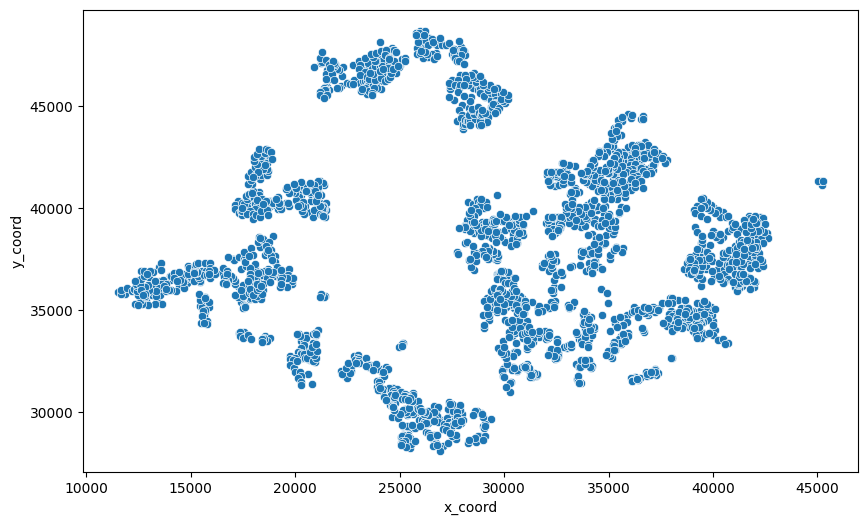

In [9]:
# set the plot of data for k-means clustering data - based on multiple datasets from the short-term parking, night parking, and free parking
carparks = set()
location = dict()
for index,row in coordinate_carparksinfo[["car_park_no","x_coord","y_coord"]].iterrows():
    carparks.add(row["car_park_no"])
    if row["car_park_no"] not in location:
        location[row["car_park_no"]] = [row["x_coord"],row["y_coord"]]
print(len(carparks),len(location))

# Plot with seaborn, using car_park_type as hue and adjusting the legend position
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
scatter_plot = sns.scatterplot(data=coordinate_carparksinfo, x="x_coord", y="y_coord")

# Move legend outside of the plot area to avoid blocking
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Car Park Type")
#scatter_plot = sns.scatterplot(data=coordinate_carparksinfo, x="x_coord", y="y_coord", hue="car_park_type", palette="Set1")
# Annotate each point with the car_park_no




# Display the plot
plt.show()

<Axes: xlabel='x_coord', ylabel='y_coord'>

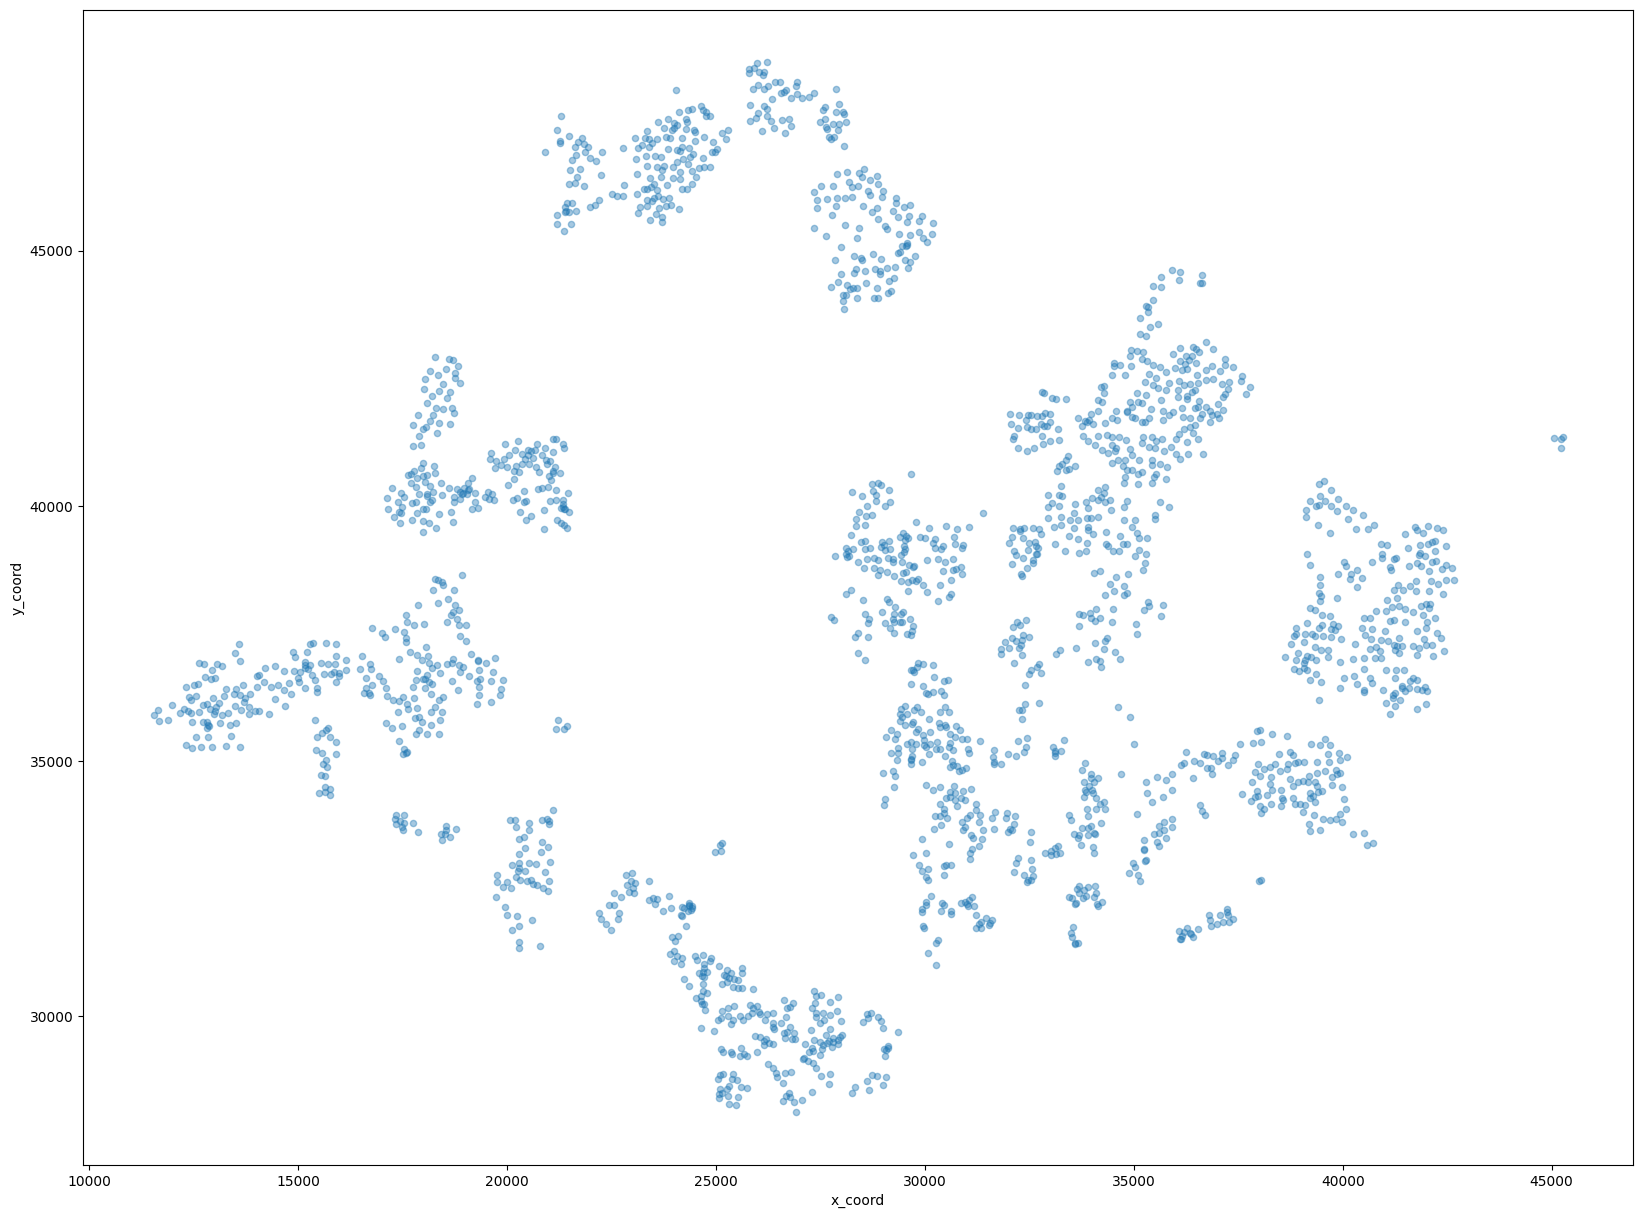

In [110]:
coordinate_carparksinfo.plot(x="x_coord",y="y_coord",kind="scatter",alpha=0.4,figsize=(20,15))

In [10]:
scale = StandardScaler()
coordinate_carparksinfo[["x_coord_T","y_coord_T"]] = scale.fit_transform(coordinate_carparksinfo[["x_coord","y_coord"]])

C:\Users\power\AppData\Local\Temp\ipykernel_36000\719813884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinate_carparksinfo[["x_coord_T","y_coord_T"]] = scale.fit_transform(coordinate_carparksinfo[["x_coord","y_coord"]])
C:\Users\power\AppData\Local\Temp\ipykernel_36000\719813884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinate_carparksinfo[["x_coord_T","y_coord_T"]] = scale.fit_transform(coordinate_carparksinfo[["x_coord","y_coord"]])


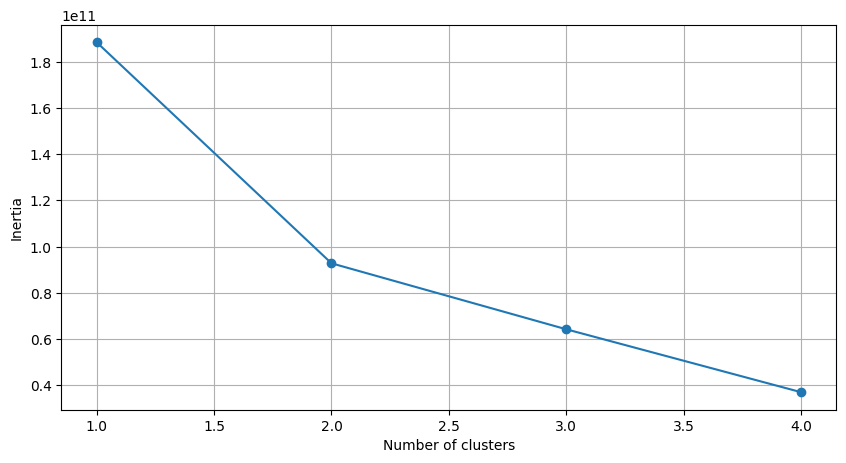

In [11]:

CLUSTER_COUNT = 5
def optimise_k_means(data,max_k):
    means = []
    inertias = []
    
    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()
    
#max k - set to 50 to test out the cluster plots
optimise_k_means(coordinate_carparksinfo[["x_coord", "y_coord"]], 5)

Enable to look at the grid of the data plot and prepare for any further processing
from the graph we can see that the elbow joint forms and decrease sharlpy at the k = 5 mark and adding more cluster beyond k = 5 will provide diminishing returns 

In [12]:
#Expand further on the k-means clustering - and create clusters labels using the -short term parking, etc to generate
kmeans = KMeans(n_clusters = CLUSTER_COUNT,random_state = 1)
kmeans.fit(coordinate_carparksinfo[["x_coord_T","y_coord_T"]])

KMeans(n_clusters=5, random_state=1)

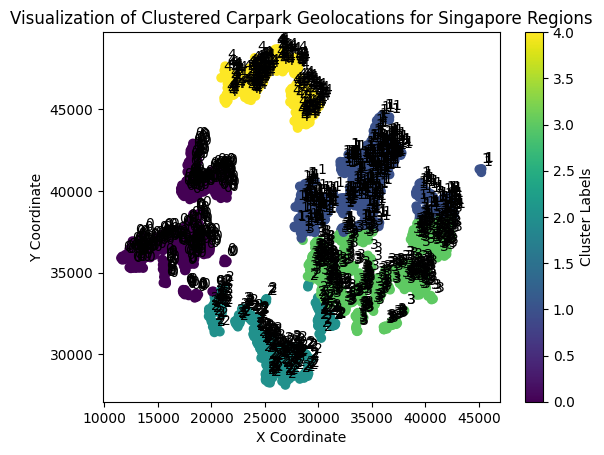

PermissionError: [Errno 13] Permission denied: 'clustered_carparks.csv'

In [14]:
coordinate_carparksinfo["kmeans"] = kmeans.labels_
coordinate_carparksinfo = coordinate_carparksinfo[["car_park_no", "x_coord", "y_coord", "kmeans"]]

# Create scatter plot
plt.scatter(
    x=coordinate_carparksinfo["x_coord"], 
    y=coordinate_carparksinfo["y_coord"], 
    c=coordinate_carparksinfo["kmeans"], 
    cmap='viridis'
)
plt.title("Visualization of Clustered Carpark Geolocations for Singapore Regions")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Annotate points with their k-means labels
for _, row in coordinate_carparksinfo.iterrows():
    plt.annotate(
        str(row["kmeans"]), 
        (row["x_coord"], row["y_coord"]), 
        textcoords="offset points", 
        xytext=(5, 5), 
        ha="center"
    )

plt.colorbar(label="Cluster Labels")
plt.show()

#coordinate_carparksinfo.to_csv("clustered_carparks.csv", index=False)

# Creating the Cluster Labels(for additional features to be added to the training set to feed into xgboost)



In [ ]:
print(coordinate_carparksinfo.columns)


Index(['car_park_no', 'x_coord', 'y_coord', 'kmeans'], dtype='object')


C:\Users\power\AppData\Local\Temp\ipykernel_21668\211587966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinate_carparksinfo['car_park_type_encoded'] = coordinate_carparksinfo['car_park_type'].astype("category").cat.codes
C:\Users\power\AppData\Local\Temp\ipykernel_21668\211587966.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coordinate_carparksinfo['cluster_label'] = kmeans.fit_predict(coordinate_carparksinfo[['x_coord', 'y_coord', 'car_park_type_encoded']])


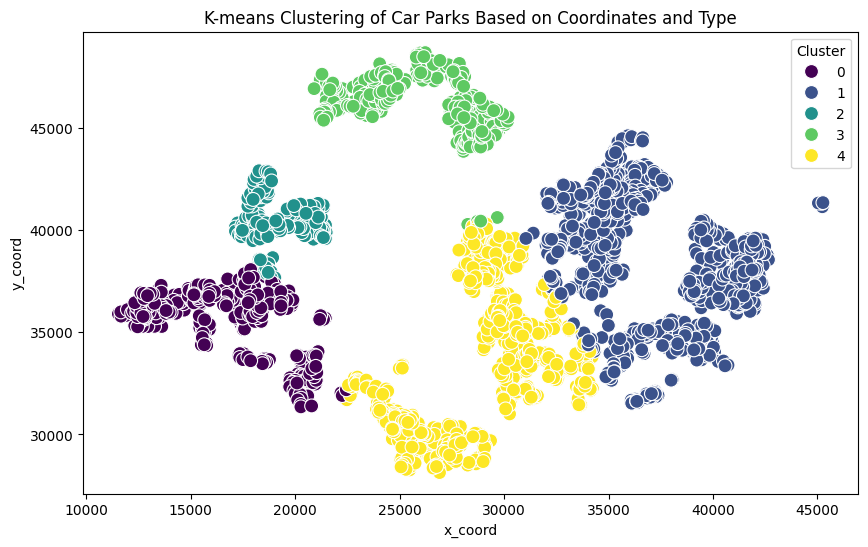

Enhanced dataset saved as 'Carpark_Info_With_Clusters.csv'


In [127]:

if coordinate_carparksinfo['car_park_type'].dtype == 'object':
    coordinate_carparksinfo['car_park_type_encoded'] = coordinate_carparksinfo['car_park_type'].astype("category").cat.codes

# Perform K-means clustering on selected features
kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=1)
coordinate_carparksinfo['cluster_label'] = kmeans.fit_predict(coordinate_carparksinfo[['x_coord', 'y_coord', 'car_park_type_encoded']])

# Optional: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=coordinate_carparksinfo, x="x_coord", y="y_coord", hue="cluster_label", palette="viridis", s=100, marker='o')
plt.title("K-means Clustering of Car Parks Based on Coordinates and Type")
plt.legend(title="Cluster")
plt.show()

# Save the updated dataset with cluster labels to use for XGBoost training
coordinate_carparksinfo.to_csv("Carpark_Info_With_Clusters.csv", index=False)
print("Enhanced dataset saved as 'Carpark_Info_With_Clusters.csv'")

1) the clusters labels are used to seperate carpark and group them based on their respective carpakr code's for eg. carpark_encode[0,1,2,3,4,5,6] - hot encoded will be representing the 0 - basement carpark, 1 - covered carpark, 2, 3 - Merchandise carpark, 4 - multi-storey carpark, 5- Surface carpark, surface multi-storey carpark

2) Cluster labels - categorize based on the nearest coordinates/neighbours and unsupervised learns from relevant features of the carpark encode[0,1,2,3,4,5,6]

3) Sectors are categorized by the different regions such as East, West, North-East, South, North


### Create a combined dataset for training with features attributes s, reformatting timestamp(day, hour, hour of the week) - done, carpark_number(done), carpark_type (One Hot encoded) - done, availability_rati - done, sector(done), rainfall(done)

In [ ]:
#Final Combinations of the dataset - link up the the carpark information first(Sector), encoded carpark type 
# filepath 1 = "C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\clustered_carparks_sector.csv"
# filepath 2 = "C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\Carpark_type_encoded.csv"


# File paths for the two datasets
filepath1 = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\clustered_carparks_sector.csv"
filepath2 = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\Carpark_type_encoded.csv"

# Load the datasets
carpark_sector_data = pd.read_csv(filepath1)
carpark_type_data = pd.read_csv(filepath2)

carpark_type_selected = carpark_type_data[['car_park_no', 'car_park_type', 'car_park_type_encoded', 'cluster_label']]
carpark_sector_selected = carpark_sector_data[['car_park_no', 'kmeans', 'Sector', "x_coord", "y_coord"]]

# Merge the two datasets on 'car_park_no'
combined_data = pd.merge(carpark_type_selected, carpark_sector_selected, how="inner", on="car_park_no")

# Save the combined dataset to a new CSV file
output_combined_path = "Combined_Carpark_Data_with_Selected_Columns.csv"
#combined_data.to_csv(output_combined_path, index=False)

#Combine the file into a single csv


### Start the XGBoost Modelling and training of the data - use multiple parameters to feed in the datasets to train multiple times (xgboost) - try matching with different datasets and experimentation 

In [57]:
## load the data and align horizontal the data 

#concat training datasets 
dataset1_load = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\TRAINING_Datasets\Yearly_Carpark_Availability_With_Lags_And_Time_Features.csv"
dataset2_load = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\Rain_Fall_Final(Aug_2024).csv"
dataset3_load = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\Combined_Carpark_Data_with_Selected_Columns.csv"

dataread1 = pd.read_csv(dataset1_load)
dataread2 = pd.read_csv(dataset2_load)
dataread3 = pd.read_csv(dataset3_load)

final_data_train = pd.concat([dataread1, dataread2, dataread3], axis=1)


#concat testing datasets 



dataset1_test = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\Tests_Data\Carpark_Availability_Aug2024_Lag_Time.csv"
dataset2_test = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\HDBCarparkInformation\Combined_Carpark_Data_with_Selected_Columns.csv"
dataset3_test = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\Rain_Fall_Final(Aug_2024).csv"

dataread1_test = pd.read_csv(dataset1_test)
dataread2_test = pd.read_csv(dataset2_test)
dataread3_test = pd.read_csv(dataset3_test)


final_data_test = pd.concat([dataread1_test, dataread2_test, dataread3_test], axis=1)

print(final_data_train.head())




                   timestamp  average_availability     lag_1   lag_168  \
0  2021-08-08 07:59:27+08:00              0.412880  0.405901  0.421854   
1  2021-08-08 08:59:27+08:00              0.420016  0.412880  0.417931   
2  2021-08-08 09:59:27+08:00              0.433466  0.420016  0.415368   
3  2021-08-08 10:59:27+08:00              0.443019  0.433466  0.410828   
4  2021-08-08 11:59:27+08:00              0.450629  0.443019  0.406744   

   day_of_week  hour_of_day  hour_of_week                  timestamp  \
0          6.0          7.0         151.0  2024-08-03 19:00:00+08:00   
1          6.0          8.0         152.0  2024-08-03 19:00:00+08:00   
2          6.0          9.0         153.0  2024-08-03 19:00:00+08:00   
3          6.0         10.0         154.0  2024-08-03 19:00:00+08:00   
4          6.0         11.0         155.0  2024-08-03 19:00:00+08:00   

  station_id  rainfall_value  ... hourly  week_of_hour  car_park_no  \
0       S107           0.200  ...   19.0         13

In [56]:
print(final_data_test.head())

                   timestamp  average_availability     lag_1   lag_168  \
0  2024-08-08 07:59:27+08:00              0.532442  0.487825  0.436470   
1  2024-08-08 08:59:27+08:00              0.578217  0.532442  0.432614   
2  2024-08-08 09:59:26+08:00              0.590394  0.578217  0.431024   
3  2024-08-08 10:59:27+08:00              0.599040  0.590394  0.429178   
4  2024-08-08 11:59:27+08:00              0.589153  0.599040  0.427926   

   day_of_week  hour_of_day  hour_of_week car_park_no          car_park_type  \
0          3.0          7.0          79.0         ACB      BASEMENT CAR PARK   
1          3.0          8.0          80.0         ACM  MULTI-STOREY CAR PARK   
2          3.0          9.0          81.0         AH1       SURFACE CAR PARK   
3          3.0         10.0          82.0        AK19       SURFACE CAR PARK   
4          3.0         11.0          83.0        AK31       SURFACE CAR PARK   

   car_park_type_encoded  ...      Sector     x_coord     y_coord  \
0    

In [ ]:
#Ensure alignment of features for both the datasets(train, test) / fix and 
# Ensure alignment of features between training and test datasets
common_features = list(set(final_data_train.columns).intersection(final_data_test.columns))
print(common_features)

['car_park_no', 'y_coord', 'hour_of_week', 'car_park_type', 'rainfall_value', 'station_id', 'average_availability', 'lag_168', 'x_coord', 'lag_1', 'car_park_type_encoded', 'day_of_week', 'hour_of_day', 'Rain_Conditions', 'cluster_label', 'Sector', 'week_of_hour', 'hourly', 'kmeans', 'timestamp']


In [ ]:
#remove any missing values from the dataset and any impute any missing valeus
final_data_train.dropna()
final_data_test.dropna()


,timestamp,average_availability,lag_1,lag_168,day_of_week,hour_of_day,hour_of_week,car_park_no,car_park_type,car_park_type_encoded,...,x_coord,y_coord,timestamp,station_id,rainfall_value,Rain_Conditions,day_of_week,hourly,week_of_hour,high_conjestion
3,2024-08-08 10:59:27+08:00,0.599040,0.590394,0.429178,3.0,10.0,82.0,AK19,SURFACE CAR PARK,5,...,28185.4359,39012.6664,2024-08-03 19:00:00+08:00,S84,13.00000,Heavy-Thunderstorm,6.0,19.0,139.0,0.599040
14,2024-08-08 21:59:27+08:00,0.484082,0.486026,0.606710,3.0,21.0,93.0,AM32,MULTI-STOREY CAR PARK,4,...,28117.7689,39172.0389,2024-08-04 15:00:00+08:00,S107,12.60000,Heavy-Thunderstorm,7.0,15.0,159.0,0.484082
18,2024-08-09 02:59:26+08:00,0.446349,0.450883,0.526372,4.0,2.0,98.0,AM64,MULTI-STOREY CAR PARK,4,...,30201.2360,39274.2740,2024-08-04 15:00:00+08:00,S113,7.40000,Heavy-Thunderstorm,7.0,15.0,159.0,0.446349
21,2024-08-09 05:59:27+08:00,0.438055,0.438443,0.466696,4.0,5.0,101.0,AM81,MULTI-STOREY CAR PARK,4,...,28960.3285,39294.4158,2024-08-04 15:00:00+08:00,S207,13.66800,Heavy-Thunderstorm,7.0,15.0,159.0,0.438055
22,2024-08-09 06:59:26+08:00,0.438857,0.438055,0.453922,4.0,6.0,102.0,AM96,MULTI-STOREY CAR PARK,4,...,29961.0968,38457.9118,2024-08-04 15:00:00+08:00,S208,7.34400,Heavy-Thunderstorm,7.0,15.0,159.0,0.438857
26,2024-08-09 10:59:26+08:00,0.468587,0.455560,0.429924,4.0,10.0,106.0,AR2M,MULTI-STOREY CAR PARK,4,...,22252.4860,31896.9749,2024-08-04 15:00:00+08:00,S212,11.20000,Heavy-Thunderstorm,7.0,15.0,159.0,0.468587
34,2024-08-09 18:59:27+08:00,0.499642,0.503037,0.581553,4.0,18.0,114.0,A10,SURFACE CAR PARK,5,...,29247.0300,38962.0000,2024-08-04 15:00:00+08:00,S221,5.94000,Moderate-HeavyRain,7.0,15.0,159.0,0.499642
37,2024-08-09 21:59:26+08:00,0.490806,0.499368,0.593714,4.0,21.0,117.0,A12,SURFACE CAR PARK,5,...,28605.4890,38954.8000,2024-08-04 15:00:00+08:00,S224,11.25600,Heavy-Thunderstorm,7.0,15.0,159.0,0.490806
51,2024-08-10 12:59:27+08:00,0.518182,0.518716,0.432069,5.0,12.0,132.0,A30A,SURFACE CAR PARK,5,...,29049.6606,39137.3556,2024-08-04 15:00:00+08:00,S84,5.00000,Moderate-HeavyRain,7.0,15.0,159.0,0.518182
55,2024-08-10 16:59:26+08:00,0.514675,0.518572,0.498279,5.0,16.0,136.0,A34,SURFACE CAR PARK,5,...,30042.0000,38931.4300,2024-08-04 15:00:00+08:00,S94,5.80000,Moderate-HeavyRain,7.0,15.0,159.0,0.514675


In [76]:
#Clean for infinity values or debugging 
final_data_train = final_data_train[final_data_train['high_conjestion'].apply(lambda x: x != float('inf') and x != float('-inf'))]

invalid_rows = final_data_train[final_data_train['high_conjestion'].isnull() | 
                          final_data_train['high_conjestion'].apply(lambda x: x in [float('inf'), float('-inf')])]
print(invalid_rows)


# Drop rows with NaN values in the target column
final_data_train = final_data_train.dropna(subset=['week_of_hour'])

# Filter out rows with infinity or negative infinity in the target column
final_data_train = final_data_train[final_data_train['week_of_hour'].apply(lambda x: x != float('inf') and x != float('-inf'))]

# Verify if any invalid rows remain
invalid_rows = final_data_train[final_data_train['week_of_hour'].isnull() | 
                                final_data_train['week_of_hour'].apply(lambda x: x in [float('inf'), float('-inf')])]
print(f"Number of invalid rows after cleaning: {len(invalid_rows)}")

# Ensure no invalid rows remain (assertion for debugging)
assert len(invalid_rows) == 0, "There are still invalid rows in the dataset!"

#Apply for the testing side




Empty DataFrame
Columns: [timestamp, average_availability, lag_1, lag_168, day_of_week, hour_of_day, hour_of_week, timestamp, station_id, rainfall_value, Rain_Conditions, day_of_week, hourly, week_of_hour, car_park_no, car_park_type, car_park_type_encoded, cluster_label, kmeans, Sector, x_coord, y_coord, high_conjestion]
Index: []

[0 rows x 23 columns]
Number of invalid rows after cleaning: 0


In [82]:
# Drop rows with NaN values in the target column
final_data_test = final_data_test.dropna(subset=['Rain_Conditions'])

# Filter out rows with infinity or negative infinity in the target column
final_data_test = final_data_test[final_data_test['Rain_Conditions'].apply(lambda x: x != float('inf') and x != float('-inf'))]

# Verify if any invalid rows remain
invalid_rows = final_data_test[final_data_test['Rain_Conditions'].isnull() | 
                                final_data_test['Rain_Conditions'].apply(lambda x: x in [float('inf'), float('-inf')])]
print(f"Number of invalid rows after cleaning: {len(invalid_rows)}")

# Ensure no invalid rows remain (assertion for debugging)
assert len(invalid_rows) == 0, "There are still invalid rows in the dataset!"



Number of invalid rows after cleaning: 0


In [83]:
print(final_data_train)
print(final_data_test)

                     timestamp  average_availability     lag_1   lag_168  \
0    2021-08-08 07:59:27+08:00              0.412880  0.405901  0.421854   
1    2021-08-08 08:59:27+08:00              0.420016  0.412880  0.417931   
2    2021-08-08 09:59:27+08:00              0.433466  0.420016  0.415368   
3    2021-08-08 10:59:27+08:00              0.443019  0.433466  0.410828   
4    2021-08-08 11:59:27+08:00              0.450629  0.443019  0.406744   
..                         ...                   ...       ...       ...   
746  2023-08-09 21:59:27+08:00              0.465139  0.476864  0.592486   
747  2023-08-09 22:59:27+08:00              0.454482  0.465139  0.595880   
748  2023-08-10 00:59:27+08:00              0.438094  0.454482  0.594467   
749  2023-08-10 01:59:32+08:00              0.431168  0.438094  0.589780   
750  2023-08-10 02:59:27+08:00              0.429512  0.431168  0.567281   

     day_of_week  hour_of_day  hour_of_week                  timestamp  \
0            

[0]	validation-rmse:0.06181
[1]	validation-rmse:0.05572
[2]	validation-rmse:0.05023
[3]	validation-rmse:0.04536
[4]	validation-rmse:0.04099
[5]	validation-rmse:0.03700
[6]	validation-rmse:0.03373
[7]	validation-rmse:0.03315
[8]	validation-rmse:0.03007
[9]	validation-rmse:0.02731
[10]	validation-rmse:0.02482
[11]	validation-rmse:0.02256
[12]	validation-rmse:0.02050
[13]	validation-rmse:0.01867
[14]	validation-rmse:0.01700
[15]	validation-rmse:0.01551
[16]	validation-rmse:0.01419
[17]	validation-rmse:0.01308
[18]	validation-rmse:0.01219
[19]	validation-rmse:0.01122
[20]	validation-rmse:0.01036
[21]	validation-rmse:0.00975
[22]	validation-rmse:0.00908
[23]	validation-rmse:0.00858
[24]	validation-rmse:0.00816
[25]	validation-rmse:0.00770
[26]	validation-rmse:0.00725
[27]	validation-rmse:0.00692
[28]	validation-rmse:0.00662
[29]	validation-rmse:0.00637
[30]	validation-rmse:0.00638
[31]	validation-rmse:0.00615
[32]	validation-rmse:0.00590
[33]	validation-rmse:0.00573
[34]	validation-rmse:0.0

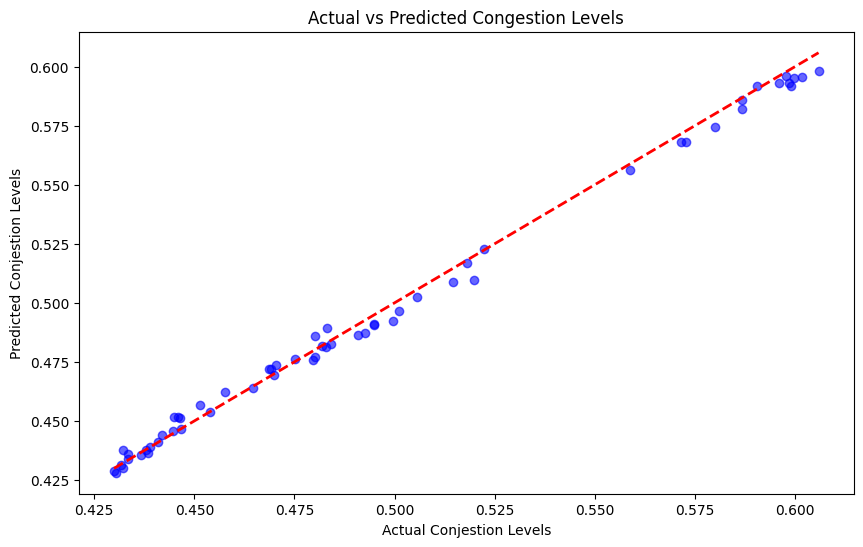

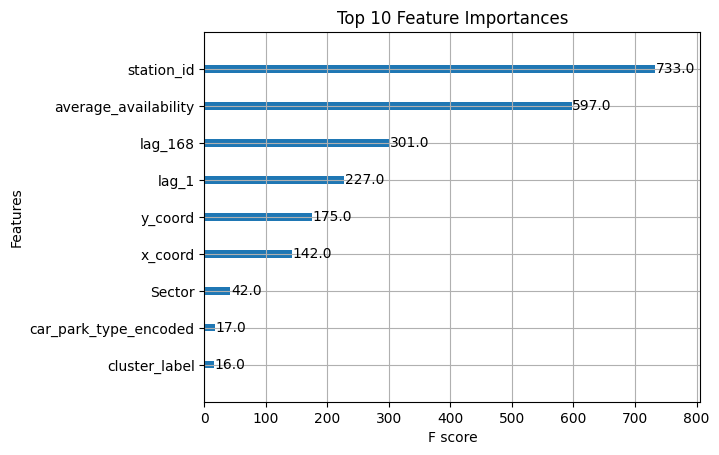

In [84]:
# Ensure features and target are from the same dataset

categorical_columns = ['Sector', 'station_id']
for col in categorical_columns:
    final_data_train[col] = final_data_train[col].astype('category')
    final_data_test[col] = final_data_test[col].astype('category')

# Define congestion threshold and rainfall condition -
rain_condition = "Heavy-Thunderstorm"
availability_threshold = 0.2  # Define average availability threshold

# Adjust target variable for continuous prediction
final_data_train['high_conjestion'] = final_data_train['average_availability']
# Adjust for heavy thunderstorms
final_data_train.loc[final_data_train['Rain_Conditions'] == rain_condition, 'high_conjestion'] *= 1.2 #inflate carpark availability 
# Adjust for low average availability
final_data_train.loc[final_data_train['average_availability'] < availability_threshold, 'high_conjestion'] *= 0.8

final_data_test['high_conjestion'] = final_data_test['average_availability']
# Adjust for heavy thunderstorms
final_data_test.loc[final_data_test['Rain_Conditions'] == rain_condition, 'high_conjestion'] *= 1.2
# Adjust for low average availability
final_data_test.loc[final_data_test['average_availability'] < availability_threshold, 'high_conjestion'] *= 0.8

# Define features and target variable
features = [
    'average_availability', 'lag_1', 'lag_168', 
    'car_park_type_encoded', 'Sector', 'x_coord', 'y_coord', 'cluster_label', 'station_id'
]
target = 'high_conjestion'


# Split the train_data into training and validation sets
X = final_data_train[features]
y = final_data_train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare datasets for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

# XGBoost parameters for regression
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'  # Use RMSE for evaluation
}

# Train the model with validation monitoring
model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dval, 'validation')],
    early_stopping_rounds=10
)

# Prepare test dataset
X_test = final_data_test[features]
y_test_actual = final_data_test[target]
dtest = xgb.DMatrix(X_test, label=y_test_actual, enable_categorical=True)

# Predict on the test dataset
y_pred = model.predict(dtest)

# Save predictions in the test dataset
final_data_test['predicted_congestion'] = y_pred

# Save the updated test dataset with predictions
#output_test_path = 'Updated_Test_Data_With_Predictions.csv'  # Replace with your desired output path
#test_data.to_csv(output_test_path, index=False)

# Evaluate the model on the test dataset
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f"Test Dataset RMSE: {rmse}")

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.6, color='blue')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r', linewidth=2)
plt.xlabel('Actual Conjestion Levels')
plt.ylabel('Predicted Conjestion Levels')
plt.title('Actual vs Predicted Congestion Levels')
plt.show()

# Feature Importance Plot
xgb.plot_importance(model, max_num_features=10, importance_type='weight', title="Top 10 Feature Importances")
plt.show()



In [86]:
#train data
july_data_2024_availability = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\TRAINING_Datasets\cleaned_july_2024.csv"
rainfall_data_july = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\hourly_rainfall_updated_july_2024 (3).csv"

july_train_data = pd.read_csv(july_data_2024_availability)
rainfall_train_july = pd.read_csv(rainfall_data_july)

july_data_train = pd.concat([july_train_data, rainfall_train_july], axis=1)

print(july_data_train)



                         timestamp carpark_number lot_type  total_lots  \
0        2024-07-01T00:30:27+08:00           HE12        C         105   
1        2024-07-01T00:30:27+08:00            HLM        C         583   
2        2024-07-01T00:30:27+08:00            RHM        C         329   
3        2024-07-01T00:30:27+08:00           BM29        C          97   
4        2024-07-01T00:30:27+08:00            Q81        C          97   
...                            ...            ...      ...         ...   
1048570  2024-07-23T08:30:27+08:00            SB7        C         421   
1048571  2024-07-23T08:30:27+08:00            SB8        C         296   
1048572  2024-07-23T08:30:27+08:00            SB9        C         486   
1048573  2024-07-23T08:30:27+08:00            W41        C         251   
1048574  2024-07-23T08:30:27+08:00            W55        C         373   

         lots_available  availability_ratio      timestamp station_id  \
0                    27            0.2

In [88]:
new_july_data = july_data_train.dropna()
print(new_july_data)




                       timestamp carpark_number lot_type  total_lots  \
0      2024-07-01T00:30:27+08:00           HE12        C         105   
1      2024-07-01T00:30:27+08:00            HLM        C         583   
2      2024-07-01T00:30:27+08:00            RHM        C         329   
3      2024-07-01T00:30:27+08:00           BM29        C          97   
4      2024-07-01T00:30:27+08:00            Q81        C          97   
...                          ...            ...      ...         ...   
46766  2024-07-01T23:30:27+08:00            T11        C         250   
46767  2024-07-01T23:30:27+08:00             T9        C         570   
46768  2024-07-01T23:30:27+08:00           C21L        C          13   
46769  2024-07-01T23:30:27+08:00            A51        C          35   
46770  2024-07-01T23:30:27+08:00           AM19        C         300   

       lots_available  availability_ratio        timestamp station_id  \
0                  27            0.257143    1/7/2024 0:00    

In [87]:
#test data basedo n july 
july_data_2024_availability = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\TRAINING_Datasets\cleaned_july_2024.csv"
rainfall_data_test = r"C:\Users\power\OneDrive\Desktop\Personal Ventures\NUS(Student Folders)\NUS(EE) - Y4S1\EE4211(Data Science)\Homework-Project\Project\External Datasets\hourly_rainfall_updated_july_2024 (3).csv"

july_test_data = pd.read_csv(july_data_2024_availability)
rainfall_test_july = pd.read_csv(rainfall_data_test)

july_data_test = pd.concat([july_test_data, rainfall_test_july], axis=1)

print(july_data_test)


                         timestamp carpark_number lot_type  total_lots  \
0        2024-07-01T00:30:27+08:00           HE12        C         105   
1        2024-07-01T00:30:27+08:00            HLM        C         583   
2        2024-07-01T00:30:27+08:00            RHM        C         329   
3        2024-07-01T00:30:27+08:00           BM29        C          97   
4        2024-07-01T00:30:27+08:00            Q81        C          97   
...                            ...            ...      ...         ...   
1048570  2024-07-23T08:30:27+08:00            SB7        C         421   
1048571  2024-07-23T08:30:27+08:00            SB8        C         296   
1048572  2024-07-23T08:30:27+08:00            SB9        C         486   
1048573  2024-07-23T08:30:27+08:00            W41        C         251   
1048574  2024-07-23T08:30:27+08:00            W55        C         373   

         lots_available  availability_ratio      timestamp station_id  \
0                    27            0.2

In [89]:
new_july_test = july_data_test.dropna()
print(new_july_test)

                       timestamp carpark_number lot_type  total_lots  \
0      2024-07-01T00:30:27+08:00           HE12        C         105   
1      2024-07-01T00:30:27+08:00            HLM        C         583   
2      2024-07-01T00:30:27+08:00            RHM        C         329   
3      2024-07-01T00:30:27+08:00           BM29        C          97   
4      2024-07-01T00:30:27+08:00            Q81        C          97   
...                          ...            ...      ...         ...   
46766  2024-07-01T23:30:27+08:00            T11        C         250   
46767  2024-07-01T23:30:27+08:00             T9        C         570   
46768  2024-07-01T23:30:27+08:00           C21L        C          13   
46769  2024-07-01T23:30:27+08:00            A51        C          35   
46770  2024-07-01T23:30:27+08:00           AM19        C         300   

       lots_available  availability_ratio        timestamp station_id  \
0                  27            0.257143    1/7/2024 0:00    

In [92]:
#Testing out with 1 month data with the training and testing dataset to predict chart - I want the x - chart values be the
 # The dataset for - show the visualization for the 
 
 # Encode categorical features


# Add lag features (lag_1 and lag_168 for temporal dependencies)
new_july_test['lag_1'] = new_july_test['availability_ratio'].shift(1)
new_july_test['lag_168'] = new_july_test['availability_ratio'].shift(168)

# Drop rows with NaN values caused by lagging
new_july_with_lag = new_july_test.dropna()

# Define features and target
features = [
    'availability_ratio', 'rainfall_indicator',
    'lag_1', 'lag_168'
] + [col for col in new_july_with_lag.columns if 'carpark_number_' in col or 'station_id_' in col]
target = 'availability_ratio'

X = new_july_with_lag[features]
y = new_july_with_lag[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical= True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical= True)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the XGBoost model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dval, 'validation')],
    early_stopping_rounds=10
)

# Predict on the validation dataset
y_pred = model.predict(dval)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

# Prepare for visualization
new_july_with_lag['predicted_availability'] = np.nan
new_july_with_lag.iloc[X_val.index, new_july_with_lag.columns.get_loc('predicted_availability')] = y_pred


# Plot actual vs predicted availability ratio over time
plt.figure(figsize=(12, 8))
plt.plot(
    new_july_with_lag['timestamp'],
    new_july_with_lag['availability_ratio'],
    label='Actual Availability Ratio',
    alpha=0.8
)
plt.plot(
    new_july_with_lag['timestamp'],
    new_july_with_lag['predicted_availability'],
    label='Predicted Availability Ratio',
    alpha=0.8,
    linestyle='--'
)

plt.xlabel('Timestamp')
plt.ylabel('Availability Ratio')
plt.title('Time-Series Forecasting: Actual vs Predicted Availability Ratio')
plt.legend()
plt.grid()
plt.show()


[0]	validation-rmse:0.21716
[1]	validation-rmse:0.19550
[2]	validation-rmse:0.17598
[3]	validation-rmse:0.15842
[4]	validation-rmse:0.15688
[5]	validation-rmse:0.14125
[6]	validation-rmse:0.14012
[7]	validation-rmse:0.12619
[8]	validation-rmse:0.11365
[9]	validation-rmse:0.10236
[10]	validation-rmse:0.10173
[11]	validation-rmse:0.10141
[12]	validation-rmse:0.09140
[13]	validation-rmse:0.08239
[14]	validation-rmse:0.08205
[15]	validation-rmse:0.07395
[16]	validation-rmse:0.06666
[17]	validation-rmse:0.06009
[18]	validation-rmse:0.05418
[19]	validation-rmse:0.04887
[20]	validation-rmse:0.04870
[21]	validation-rmse:0.04394
[22]	validation-rmse:0.04380
[23]	validation-rmse:0.03953
[24]	validation-rmse:0.03569
[25]	validation-rmse:0.03223
[26]	validation-rmse:0.02912
[27]	validation-rmse:0.02632
[28]	validation-rmse:0.02385
[29]	validation-rmse:0.02159
[30]	validation-rmse:0.01956
[31]	validation-rmse:0.01951
[32]	validation-rmse:0.01774
[33]	validation-rmse:0.01609
[34]	validation-rmse:0.0

C:\Users\power\AppData\Local\Temp\ipykernel_36000\919429271.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_july_with_lag['predicted_availability'] = np.nan


IndexError: index 46697 is out of bounds for axis 0 with size 46603

[0]	validation-rmse:0.21716
[1]	validation-rmse:0.19550
[2]	validation-rmse:0.17598
[3]	validation-rmse:0.15842
[4]	validation-rmse:0.14261
[5]	validation-rmse:0.12838
[6]	validation-rmse:0.12729
[7]	validation-rmse:0.12638
[8]	validation-rmse:0.11382
[9]	validation-rmse:0.11318
[10]	validation-rmse:0.10198
[11]	validation-rmse:0.10149
[12]	validation-rmse:0.09147
[13]	validation-rmse:0.09117
[14]	validation-rmse:0.08227
[15]	validation-rmse:0.07428
[16]	validation-rmse:0.07410
[17]	validation-rmse:0.07398
[18]	validation-rmse:0.07389
[19]	validation-rmse:0.06670
[20]	validation-rmse:0.06037
[21]	validation-rmse:0.05471
[22]	validation-rmse:0.04944
[23]	validation-rmse:0.04941
[24]	validation-rmse:0.04467
[25]	validation-rmse:0.04465
[26]	validation-rmse:0.04041
[27]	validation-rmse:0.03674
[28]	validation-rmse:0.03347
[29]	validation-rmse:0.03344
[30]	validation-rmse:0.03342
[31]	validation-rmse:0.03341
[32]	validation-rmse:0.03049
[33]	validation-rmse:0.02788
[34]	validation-rmse:0.0

C:\Users\power\AppData\Local\Temp\ipykernel_36000\3404426639.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_july_with_lag.loc[val_indices, 'predicted_availability'] = y_pred


TypeError: unhashable type: 'numpy.ndarray'

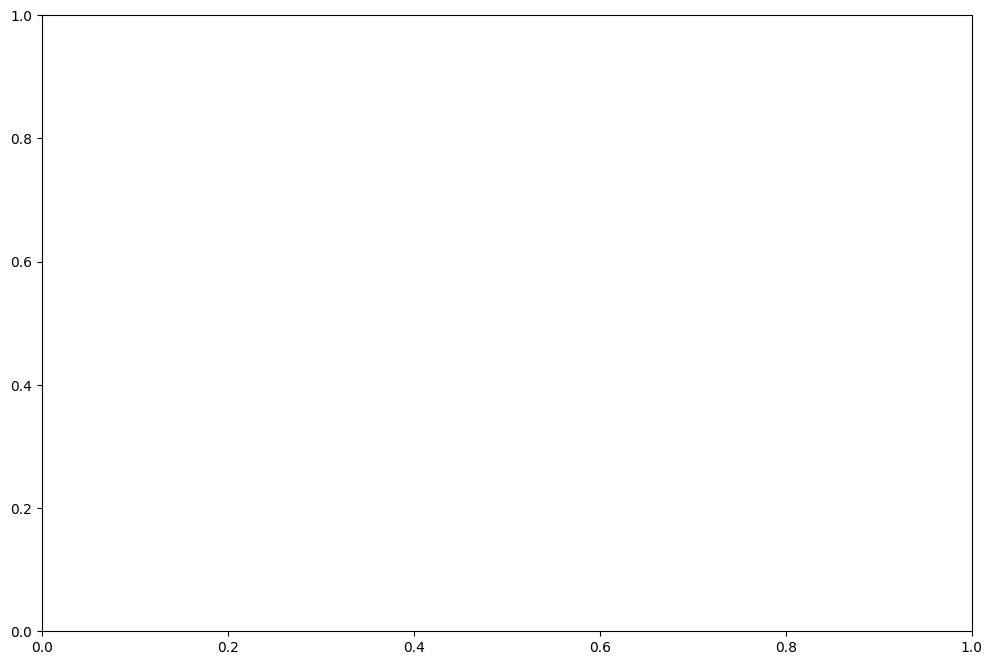

In [95]:

# Add lag features (lag_1 and lag_168 for temporal dependencies)
new_july_test['lag_1'] = new_july_test['availability_ratio'].shift(1)
new_july_test['lag_168'] = new_july_test['availability_ratio'].shift(168)

# Drop rows with NaN values caused by lagging
new_july_with_lag = new_july_test.dropna()

# Define features and target for time-series forecasting
features = ['availability_ratio', 'lag_1', 'lag_168']
target = 'availability_ratio'

X = new_july_with_lag[features]
y = new_july_with_lag[target]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Save validation indices for later use as a pandas Index
val_indices = X_val.index.to_list()

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the XGBoost model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=10
)

# Predict on the validation dataset
y_pred = model.predict(dval)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

# Assign predictions back to the original dataset using validation indices
new_july_with_lag.loc[val_indices, 'predicted_availability'] = y_pred

# Plot actual vs predicted availability ratio over time
plt.figure(figsize=(12, 8))
plt.plot(
    new_july_with_lag['timestamp'],
    new_july_with_lag['availability_ratio'],
    label='Actual Availability Ratio',
    alpha=0.8
)
plt.plot(
    new_july_with_lag['timestamp'],
    new_july_with_lag['predicted_availability'],
    label='Predicted Availability Ratio',
    alpha=0.8,
    linestyle='--'
)

plt.xlabel('Timestamp')
plt.ylabel('Availability Ratio')
plt.title('Time-Series Forecasting: Actual vs Predicted Availability Ratio')
plt.legend()
plt.grid()
plt.show()